In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader.data as web
import yfinance as yf
import datetime
import seaborn as sns
from datetime import date
from datetime import datetime
from sklearn import metrics
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, Holt, seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tools.eval_measures import rmse, meanabs
from pmdarima.arima import auto_arima

%matplotlib inline

Time Series Eval Metrics Method

In [19]:
def ts_eval_metrics(y_true, y_pred):
    print('Time Series Evaluation Metrics')
    print(f'MSE = {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE = {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE = {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'r2 = {metrics.r2_score(y_true, y_pred)}', end='\n\n')

In [20]:
aapl = yf.Ticker("SPY")

### Plot an initial time series
##### Reference
##### Chaudhari, S. (2021). Stationarity in time series analysis explained using Python. Mathematics and Econometrics. https://blog.quantinsti.com/stationarity

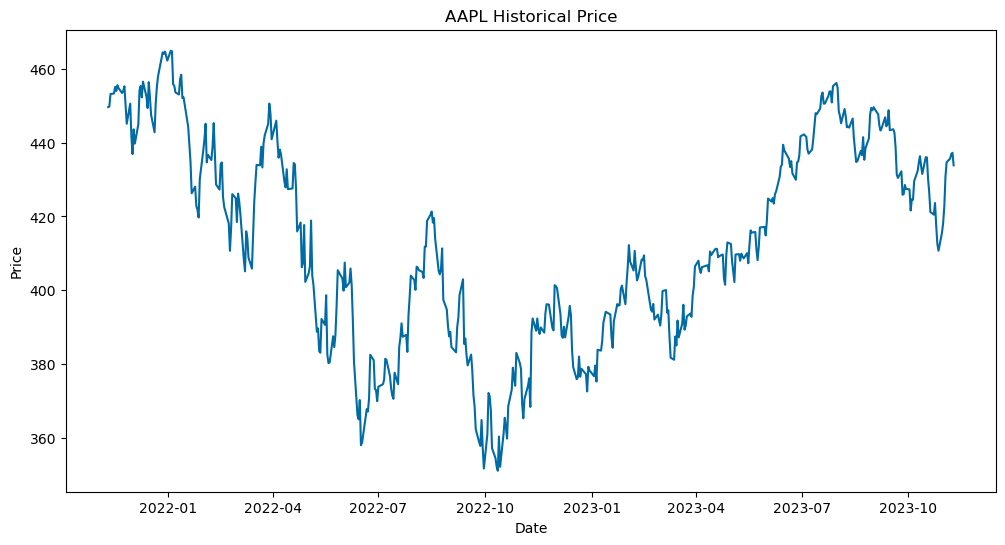

In [21]:
plt.style.use('tableau-colorblind10') #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.figure(figsize=(12, 6))
close = aapl.history(period='24mo')['Close']
plt.plot(close)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('AAPL Historical Price')
plt.show()

## Check stationarity

### Split Price into halves for statistical analysis

In [22]:
X = close.copy()
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
mean_percent_diff = (mean2 - mean1) / mean1 * 100
var1, var2 = X1.var(), X2.var()
var_percent_diff = (var2 - var1) / var1 * 100
print('mean1=%f, mean2=%3f, mean_percent_diff=%f' % (mean1, mean2, mean_percent_diff))
print('variance1=%f, variance2=%f, var_percent_diff=%f' % (var1, var2, var_percent_diff))

mean1=409.528393, mean2=415.292992, mean_percent_diff=1.407619
variance1=1010.455467, variance2=506.018413, var_percent_diff=-49.921750


### Augmented Dickey-Fuller Test
##### Check for stationarity where H0 = time series !stationary; H1 = time series = stationary
##### If p-value <= .05 or abs(test statistic)>critical value, reject H0

In [23]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -2.182850
p-value: 0.212529
Critical Values:
{'1%': -3.4434437319767452, '5%': -2.8673146875484368, '10%': -2.569845688481135}


##### P-value > .05; therefore, time series is not stationary (as expected).
##### abs(ADF Statistic) < abs(critical value) -> fail to reject H0
##### Therefore: Time series is not stationary for p-values .01, .05, and .1

### Kwiatkowski-Phillips-Schmidt-Shin test
##### KPSS is opposite of ADF where H0 = time series = stationary; H1 = time series !stationary
##### If p-value <= .05 || abs(KPSS test statistic)>critical value -> reject H0 -> therefore, !stationary

In [24]:
result = kpss(X)
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[3])

(0.8022130389455345, 0.01, 12, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 0.80
p-value: 0.010000
Critical Values:
{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


/Users/johnvincent/Library/r-miniconda-arm64/envs/r-reticulate/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


##### P-value < .05; therefore, not stationary

### Transform into stationary series

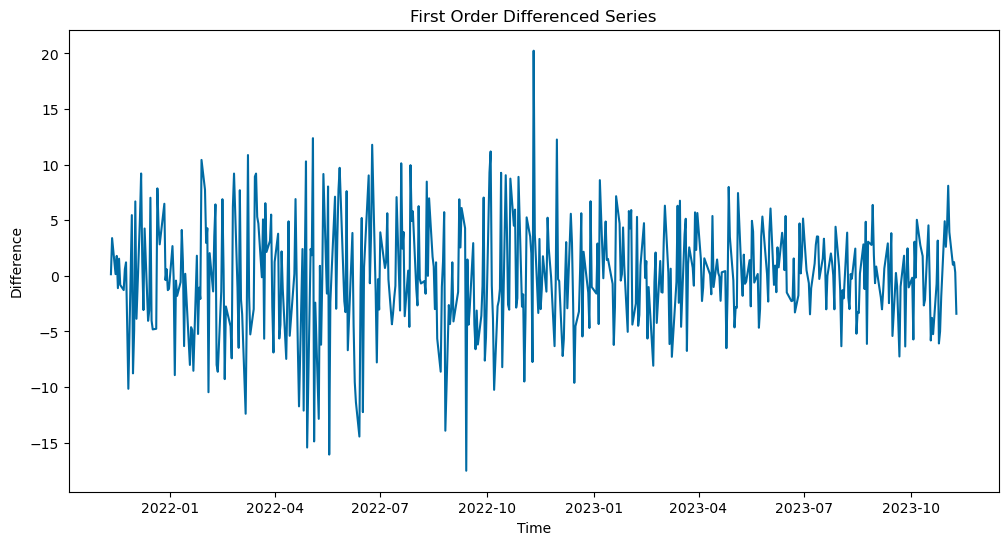

In [25]:
X['Difference'] = X.diff()
plt.figure(figsize=(12,6))
plt.plot(X['Difference'])
plt.title('First Order Differenced Series')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.show()

In [26]:
result = adfuller(X.Difference.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -21.971820
p-value: 0.000000
Critical Values:
{'1%': -3.443470002903981, '5%': -2.867326248740681, '10%': -2.569851849873108}


(ADF) P-value < .05; therefore, AAPL price series is a difference-stationary series.

### Smoothing Methods
##### Reference
https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

### Triple Exponential Smoothing
##### Use because we assume these time series have level, trends, seasonality, and noise
##### https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

In [27]:
# Using method from Brownlee, J. (2020).
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

## Time Series Prediction
### Data partition
#### 2 years train; last 1 year validation

In [28]:
close = aapl.history(period='36mo')['Close']
print(len(close))
close_train = close.iloc[:506]
close_valid = close.iloc[-260:]

755


## Simple Exponential forecaster
### Plot an initial time series
##### Reference: Module 1

In [29]:
# Forecast 12 months ahead
ses_model = SimpleExpSmoothing(close_train).fit()

ses_pred = ses_model.forecast(steps=len(close_valid))
ses_eval_metrics = ts_eval_metrics(close_valid, ses_pred)

Time Series Evaluation Metrics
MSE = 1009.001399978389
MAE = 25.411811588162173
RMSE = 31.764782385188617
MAPE = 0.05926409728694376
r2 = -0.8516136942150228



/Users/johnvincent/Library/r-miniconda-arm64/envs/r-reticulate/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/johnvincent/Library/r-miniconda-arm64/envs/r-reticulate/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


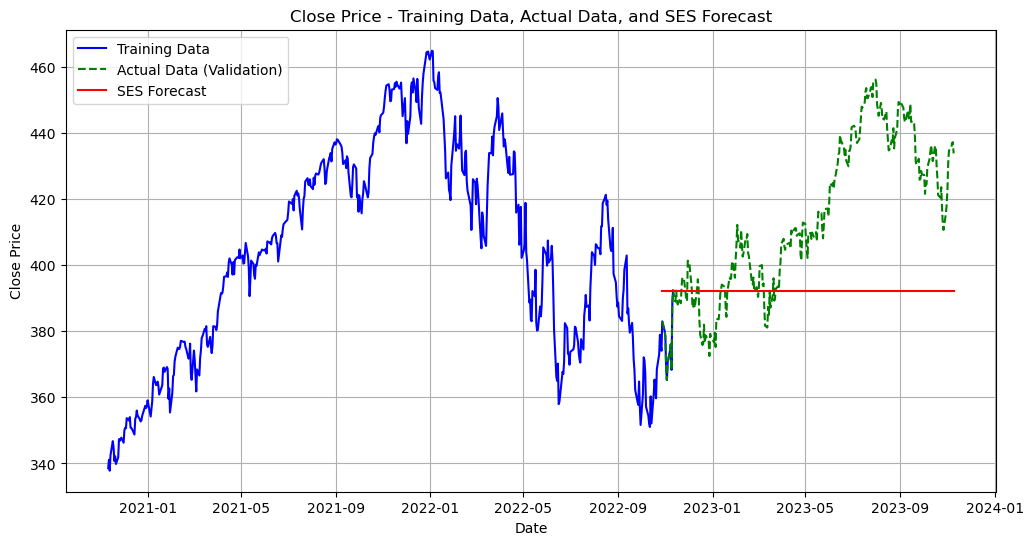

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, ses_pred, label='SES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and SES Forecast')
plt.legend()
plt.grid(True)
plt.show()

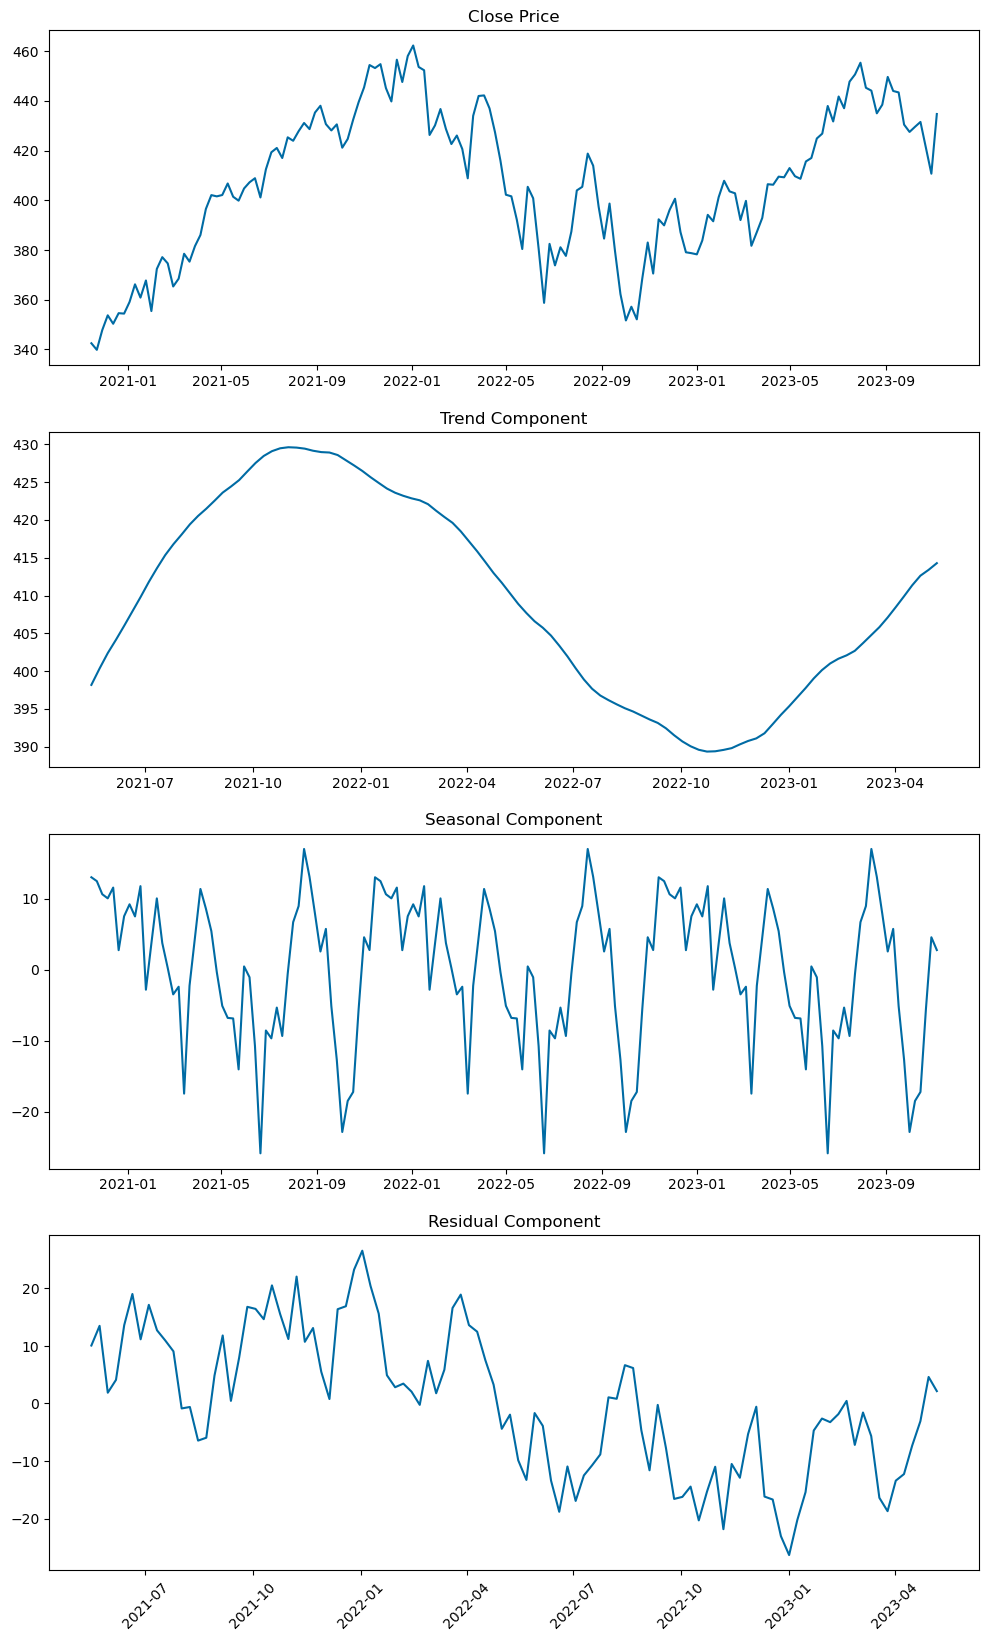

In [32]:
#### WORKING IN PROGRESS to be investigate ######

# #impute
close = close.asfreq('W')
close = close.ffill()

decomposition = seasonal_decompose(close, model='additive')
#decomposition.plot()

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(close)
axs[1].plot(trend)
axs[2].plot(seasonal)
axs[3].plot(residual)




### Plot autocorrelation

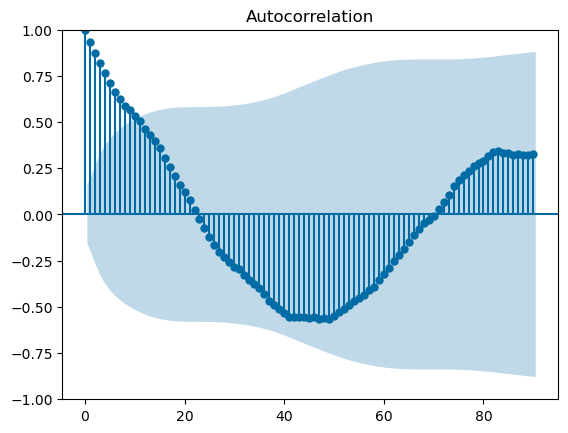

In [36]:
plot_acf(close, lags=90)  # Adjust the number of lags as needed
plt.show()

#### to be investigate ######

In [39]:
aes_model = ExponentialSmoothing(close_train, 
                                 trend='add', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'mul', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 65, 
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'
aes_model = aes_model.fit(smoothing_level=.1, smoothing_trend=0.1)

aes_pred = aes_model.forecast(steps=len(close_valid))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

Time Series Evaluation Metrics
MSE = 235.5627618065859
MAE = 13.345582066949534
RMSE = 15.348054007156279
MAPE = 0.032408375742232674
r2 = 0.5677198905595888

None


/Users/johnvincent/Library/r-miniconda-arm64/envs/r-reticulate/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/johnvincent/Library/r-miniconda-arm64/envs/r-reticulate/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


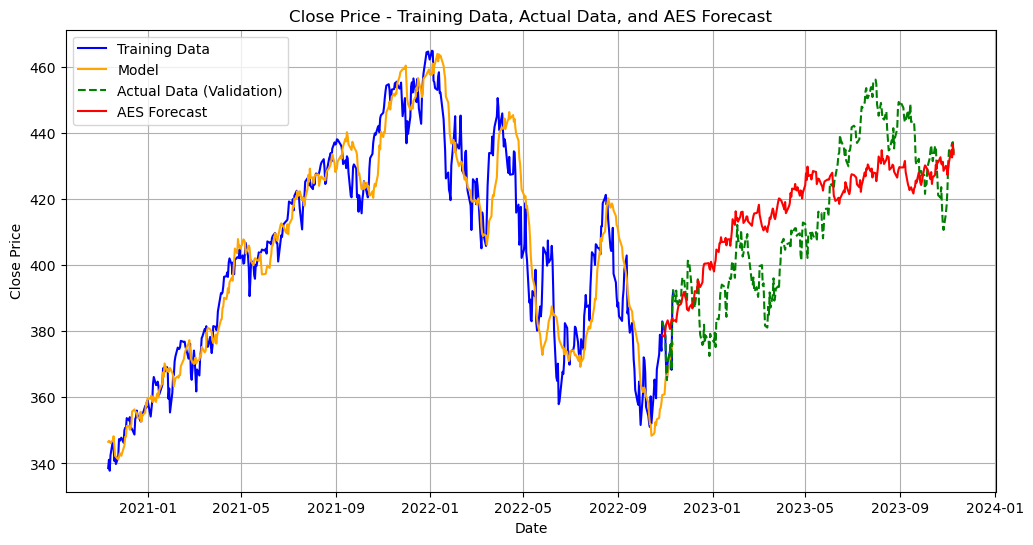

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

## Autoregression Integrated Moving Average (ARIMA)
##### Reference:
##### Brownlee, J. (2020). How to create an ARIMA model for time series forecasting in Python. Machine Learning Mastery. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python

In [41]:
### WORKING IN PROGRESS ###
# Auto regression integrated moving average; Find best (p,d,q) by using auto_arima function
auto_arima_model = auto_arima(close_train, seasonal=True, stepwise=True, trace=True)
auto_arima_model.summary()

#### WORKING IN PROGRESS ###

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3023.957, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3017.259, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3019.250, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3019.249, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3015.509, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3020.033, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.281 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  506
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1506.755
Date:                Thu, 09 Nov 2023   AIC                           3015.509
Time:                        18:21:02   BIC                           3019.734
Sample:                             0   HQIC                          3017.166
                                - 506                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        22.8618      1.118     20.451      0.000      20.671      25.053
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                44.48
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               4.35   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
aapl.income_stmt

In [ ]:
aapl.quarterly_income_stmt

In [ ]:
aapl.balance_sheet

In [ ]:
aapl.quarterly_cashflow

In [ ]:
aapl.major_holders

In [ ]:
aapl.institutional_holders

In [ ]:
aapl.mutualfund_holders

In [ ]:
aapl.news

In [ ]:
yf.pdr_override()

y_symbols = ['^GSPC', 'ES=F', 'NQ=F', 'YM=F', '^RUT', '^DJT', '^GDAXI', '^N225', '^SSMI', '^STOXX50E', '^FCHI', '^GSPTSE', '^HSI', '000001.SS', '^KS11', '^NSEI', '^AXJO']
stocks = ['^SPX']

In [ ]:
startdate = datetime.datetime(2020,3,16)
today = date.today()
enddate = today

In [ ]:
indices = web.get_data_yahoo(y_symbols, start=startdate, end=enddate)
stocks = web.get_data_yahoo(stocks, start=startdate, end=enddate)

In [ ]:
stocks

In [ ]:
aapl.history(period='1mo')

In [ ]:
aapl.get_shares_full(start="2022-01-01", end=None)

In [ ]:
opt_df = aapl.option_chain('2023-11-10')
call = opt_df.calls
put = opt_df.puts
put

In [ ]:
ax = put.boxplot(return_type='axes', rot=45, figsize=(12, 6))
ax.set_xlabel("Variable")
ax.set_ylabel("Value")
ax.set_title("Boxplot of Variable Raw Values")
plt.show()

In [ ]:
put.describe()

In [ ]:
df_temp

In [ ]:
aapl.options

## Amazon  - Gabi in progress

In [ ]:
# Download market data for Amazon: 

amzn = yf.Ticker("AMZN")
amzn.history_metadata

In [ ]:
# Import Amazon stock dataset: 

amzn = amzn.history(period="5y")
amzn_df = pd.DataFrame(amzn)

display(amzn_df.head(5))
display(amzn_df.tail(5))
display(amzn_df.describe())

In [ ]:
# Plot initial Amazon stock time series at 5y time point: 

plt.figure(figsize=(8, 4))
plt.plot(amzn_df['Close'], label='Close', color='pink')
plt.plot(amzn_df['Open'], label='Open', color='green', linestyle='--')
plt.plot(amzn_df['High'], label='High', color='blue', linestyle='dotted')
plt.plot(amzn_df['Low'], label='Low', color='teal', linestyle='dashdot')

for year in range(2019,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

    
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Partition train and validation datasets: 

train = amzn_df.loc['2018-11-09':'2022-12-01']
valid = amzn_df.loc['2022-12-02':'2023-11-08']

### STL Decoposition Using Locally Estimated Scatterplot Smoothing (LOESS)

In [ ]:
# Fit close stock price dataset to STL: 

train = train['Close'].asfreq('D')
amzn_stl = train.ffill()

stl = STL(amzn_stl, period=12)
result = stl.fit()

In [ ]:
# Identify seasonal, trend, resid:

seasonal, trend, resid = result.seasonal, result.trend, result.resid

In [ ]:
# Plot decomposition:

plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(amzn_stl)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

In [ ]:
# Plot original Amazon Close time series vs Forecasted time series: 

estimated = trend + seasonal
plt.figure(figsize=(12,4))
plt.plot(amzn_stl, label='Original', color = 'teal')
plt.plot(estimated, label ='Estimated', color = 'pink')

plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

### Anomaly Detection

In [ ]:
# Taking residuals and detecting anomaly at 3std. dev: 

resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

In [ ]:
# Plot residual threshold: 

plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(2018,11,9), datetime(2022,12,1)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2018,9,1), datetime(2023,1,1))

In [ ]:
# Identify anomalies by setting the residuals upper and lower limits:

anomalies = amzn_stl[(resid < lower) | (resid > upper)]

In [ ]:
# Plot identified residual anomalies:    ********In Progress*******

plt.figure(figsize=(10,4))
plt.plot(amzn_stl)

for year in range(2018,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
    
plt.scatter(anomalies.index, anomalies.interest, color='r', marker='D')

In [ ]:
# Anomalies identified outside 3std dev of residuals: 

anomalies

Code References: 
    
 https://github.com/ritvikmath/Time-Series-Analysis/blob/master/STL%20Decomposition.ipynb   
    